# Reputation Explorer

So you're active on [Stack Overflow](http://stackoverflow.com/) or another site in the Stack Exchange network.

If you're curious, you can find a lot of data about exactly how you've accumulated reputation using [Stack Exchange Data Explorer](https://data.stackexchange.com/). However, data about *when* your reputation was gained or lost is not accessible here. 

What do you do if, for instance, you want to see exactly how one of your answers have been voted on over time? This notebook shows a simple way to find, clean and then dig into this data using [pandas](http://pandas.pydata.org/).

## Getting the raw data

The first step is to log in to your account and navigate to the *reputation* subdirectory, e.g. [stackoverflow.com/reputation](http://stackoverflow.com/reputation). You should see a lot of lines of text containing dates and numbers decribing reputation gains and losses. For more information about this page see [here](http://meta.stackexchange.com/questions/43004/how-do-i-audit-my-reputation).

Save this huge wall of text to a file 'rep.txt' in your working directory. The first line of the file will look something like this:

In [45]:
!head -n15 rep.txt # on Unix systems

total votes: 3865
 2  25210096 (5)
 2  25210096 (5)
 1  25210517 (2)
-- 2014-08-08 rep +12   = 13        
 2  25222542 (10)
 2  25222542 (10)
 2  25222542 (10)
 2  25222542 (10)
-- 2014-08-09 rep +40   = 53        
 2  25240280 (10)
 2  25240280 (10)
 2  25233555 (10)
 1  25233555 (15)
-- 2014-08-11 rep +45   = 98        


## Cleaning the raw data

To process this big block of free text into something more structured we're going to need some helper functions.

The general idea here is to first group the lines of the raw data into alternating blocks of reputation changes and dates. Useful data will then extracted from each line of each block; each reputation change event will be combined with the date on which it occurred.

In [1]:
import itertools
import re

def is_date_line(line):
    # date lines have the following form:
    # -- 2016-01-01 rep +20   = 1003
    return bool(re.match('-- [0-9\-]{10}', line))

def extract_date_from_date_line(line):
    return line.split(None, 2)[1]

def is_rep_line(line):
    # ignoring date lines, rep lines are 
    # those that do not begin with '--', e.g.:
    #  3 2134521  10
    return not line.startswith('--')

def extract_data_from_rep_line(line):
    data = line.split()
    data[2] = data[2].strip('()[]')
    return [int(d) for d in data]

def make_date_rep_blocks(raw_data):
    # The data we're interested in lies between lines 1 and -13
    useful_data = raw_data[1:-13]
    # Group these lines into dates blocks and rep change blocks
    return [list(v) for k,v in itertools.groupby(useful_data, key=is_date_line)]

def clean_rep_block(block):
    return [extract_data_from_rep_line(line) for line in block if is_rep_line(line)]

def combine_date_with_rep_data(date_string, rep_data_block):
    return [[date_string]+line for line in rep_data_block]

def structure_data(raw_data):
    """
    Convert the raw data to a list of lists. 
    Returns: [[date, rep_type, post_id, rep_change], ...]
    """
    data = make_date_rep_blocks(raw_data)
    dates = (extract_date_from_date_line(date_block[0]) for date_block in data[1::2])
    rep_data = (clean_rep_block(block) for block in data[0::2])
    final_blocks = (combine_date_with_rep_data(*pair) for pair in zip(dates, rep_data))
    return [line for block in final_blocks for line in block]

Now we can read in the raw data and parse it into a nicer format:

In [2]:
with open('rep.txt', 'r') as f:
    raw_data = f.readlines()

data = structure_data(raw_data)

`data` is a list of lists, each containing a date, a reputation change *type* (for example 2 means upvote, 3 means downvote), a post ID associated with the change in reputation, and the number of reputation points gained or lost:

In [3]:
data[:10]

[['2014-08-08', 2, 25210096, 5],
 ['2014-08-08', 2, 25210096, 5],
 ['2014-08-08', 1, 25210517, 2],
 ['2014-08-09', 2, 25222542, 10],
 ['2014-08-09', 2, 25222542, 10],
 ['2014-08-09', 2, 25222542, 10],
 ['2014-08-09', 2, 25222542, 10],
 ['2014-08-11', 2, 25240280, 10],
 ['2014-08-11', 2, 25240280, 10],
 ['2014-08-11', 2, 25233555, 10]]

## Exploring the data with pandas

We can easily put this structured data into a pandas DataFrame. After that, we can slice, dice and plot it however we like.

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import pandas as pd

In [24]:
df = pd.DataFrame(data, columns=['date', 'rep_type', 'post_id', 'rep_change'])
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.head(10)

,date,rep_type,post_id,rep_change
0,2014-08-08,2,25210096,5
1,2014-08-08,2,25210096,5
2,2014-08-08,1,25210517,2
3,2014-08-09,2,25222542,10
4,2014-08-09,2,25222542,10
5,2014-08-09,2,25222542,10
6,2014-08-09,2,25222542,10
7,2014-08-11,2,25240280,10
8,2014-08-11,2,25240280,10
9,2014-08-11,2,25233555,10




To begin, I'll pick a couple of answers I wrote a while ago ([25774395](http://stackoverflow.com/a/25774395/3923281) and [31593712](http://stackoverflow.com/a/31593712/3923281)). Plotting cumulative upvotes against dates, I can see that one has recently increased in popularity, while the other is getting a steady trickle of upvotes:

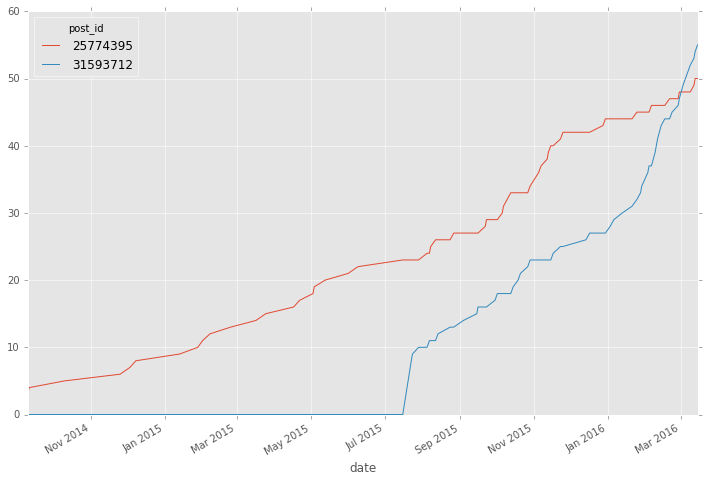

In [10]:
# subset of DataFrame containing upvotes for post IDs
df2 = df.loc[(df['rep_type'] == 2) & (df['post_id'].isin([25774395, 31593712]))]

# count the number of upvotes for each question on each date
grouped = df2.groupby(['date', 'post_id']).size()
# unstack, find the cumulative sum and then plot
grouped.unstack(level=1, fill_value=0).cumsum().plot.line();

It's also interesting to see how the number of upvotes varies over time. Using the [`resample`](http://pandas.pydata.org/pandas-docs/version/0.18.0/generated/pandas.DataFrame.resample.html) method you can specify any interval of time (I've gone for 14 days below) and count the upvotes that came your way. The one truly successful post I wrote sticks out like a sore thumb:

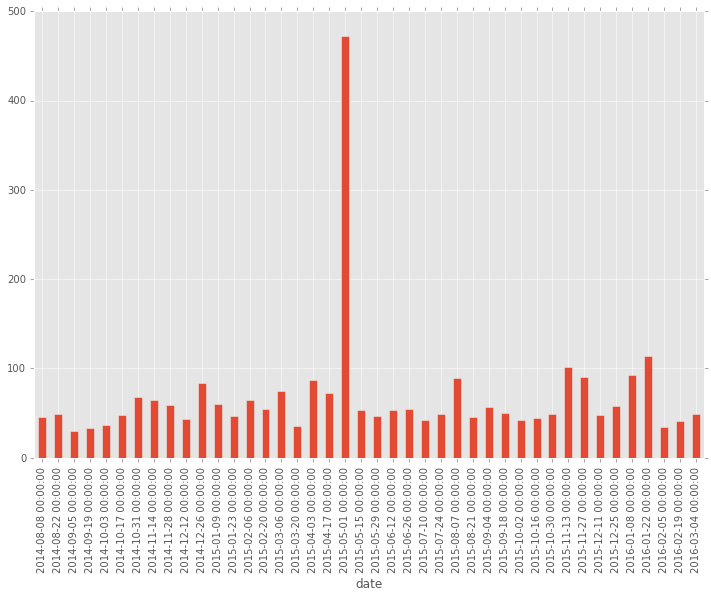

In [32]:
df2 = df.loc[df['rep_type'] == 2].set_index('date')

s = df2.resample('14d').size()
s.plot.bar();

I rarely hit the reputation cap (you can only get a maximum of 200 from upvotes each day). But on the few days I have, how many upvotes have not gained me *any* reputation?

In [39]:
df2 = df.loc[(df['rep_type'] == 2) & (df['rep_change'] == 0)]
len(df2)

319

It's still a long way to 100k for me. 

As I write this today, I've answered over 600 questions and asked 2 myself. How many *different* posts of mine are typically upvoted each day?

In [54]:
df2 = df.loc[(df['rep_type'] == 2)]

s = df2.groupby('date')['post_id'].nunique()

# fill in missing dates by reindexing
dates = pd.date_range(df.ix[0, 'date'], '2016-03-15')
s = s.reindex(dates, fill_value=0)

s.value_counts(sort=False)

0     67
1    140
2    160
3    105
4     68
5     28
6      8
7      5
8      4
9      1
Name: post_id, dtype: int64

So most frequently I have *two* upvoted posts. On roughly the same number of days I've recieved either 0 upvotes or 4 upvotes.

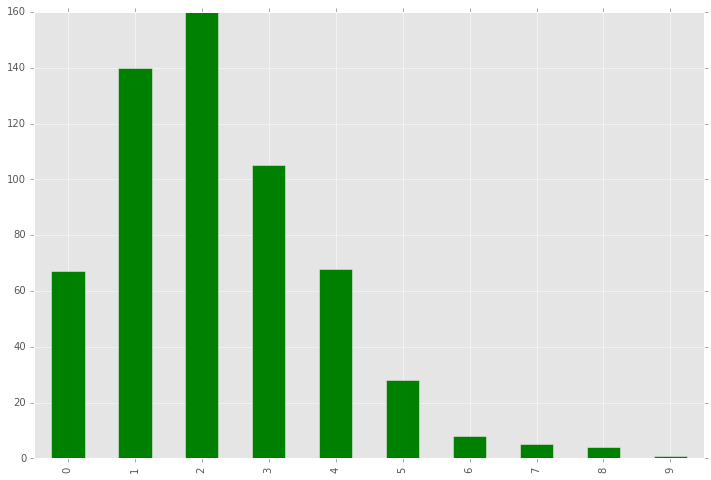

In [69]:
s.value_counts(sort=False).plot.bar(color='g');

There are many other ways that you could prod and poke this data.

One interesting way to extend the data would be to join it with tag information, number of competing answers and so on. This data could be retrieved using Stack Exchange Data Explorer.